#Import Library

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics

from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D
from keras.utils import np_utils

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import pandas as pd

plt.style.use('ggplot')

In [2]:
#Test GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# ResNet50 Model 7

In [3]:
from tensorflow.keras.applications import ResNet50
#Load the ResNet50 model
ResNet50_conv = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in ResNet50_conv.layers:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in ResNet50_conv.layers:
    print(layer, layer.trainable)

# Create the model
model = models.Sequential()
# Add the convolutional base model
model.add(ResNet50_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(13, activation='softmax'))

<keras.engine.input_layer.InputLayer object at 0x7f82ad8a7f50> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f82a14f4790> True
<keras.layers.convolutional.Conv2D object at 0x7f82a14f4750> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f82a0c86e50> True
<keras.layers.core.activation.Activation object at 0x7f82a0ca4bd0> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f82a0c55c90> True
<keras.layers.pooling.MaxPooling2D object at 0x7f82a03a6650> True
<keras.layers.convolutional.Conv2D object at 0x7f82a03a6910> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f82a03a2b10> True
<keras.layers.core.activation.Activation object at 0x7f82a03a2d10> True
<keras.layers.convolutional.Conv2D object at 0x7f82ad94b5d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f82a03d0ad0> True
<keras.layers.core.activation.Activation object at 0x7f82a03da490> True
<keras.layer

In [4]:
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [5]:
 # Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

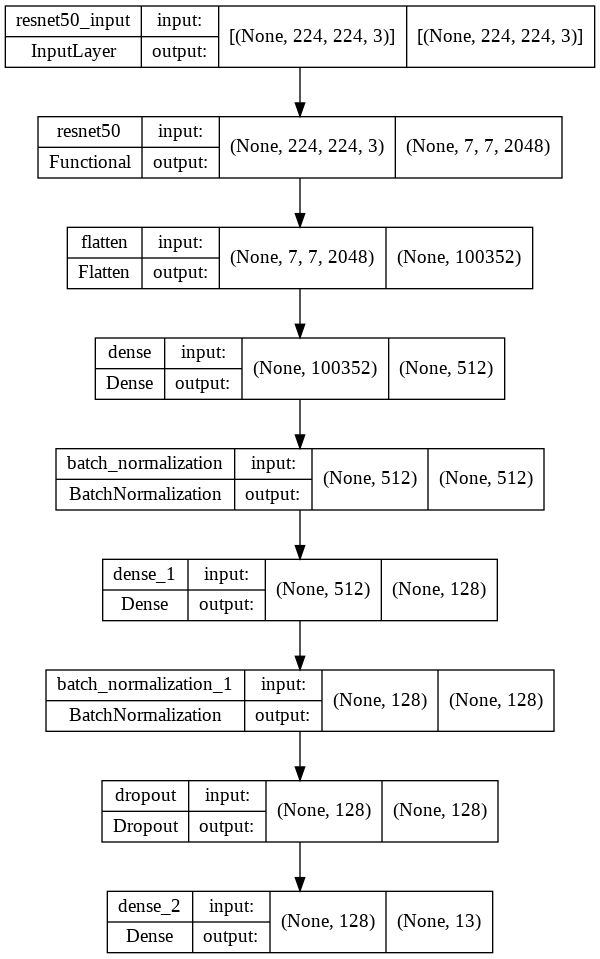

In [6]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [7]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/train/',
                                                 target_size = (224, 224),
                                                 shuffle=True)

Found 10590 images belonging to 13 classes.


In [10]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/val/',
                                            target_size = (224, 224), shuffle=False)

Found 1303 images belonging to 13 classes.


In [11]:
for cls, idx in training_set.class_indices.items():
    print('Class nr ',idx,' -> ', cls)

Class nr  0  ->  0Capri
Class nr  1  ->  10Pachy
Class nr  2  ->  12Phyll
Class nr  3  ->  14Macro
Class nr  4  ->  1Pnoep
Class nr  5  ->  2Malac
Class nr  6  ->  3Malac
Class nr  7  ->  4Anthi
Class nr  8  ->  5Anthr
Class nr  9  ->  6Corvu
Class nr  10  ->  7Dryoc
Class nr  11  ->  8Elanu
Class nr  12  ->  9Ortho


In [12]:
model_history = model.fit(training_set, batch_size=16, epochs=10, verbose=1, validation_data=(test_set))

Epoch 1/10
331/331 [==============================] - 4661s 14s/step - loss: 0.9549 - accuracy: 0.7294 - val_loss: 2.7471 - val_accuracy: 0.2126
Epoch 2/10
331/331 [==============================] - 155s 469ms/step - loss: 0.4431 - accuracy: 0.8731 - val_loss: 2.5140 - val_accuracy: 0.1926
Epoch 3/10
331/331 [==============================] - 153s 462ms/step - loss: 0.3054 - accuracy: 0.9127 - val_loss: 1.3616 - val_accuracy: 0.6339
Epoch 4/10
331/331 [==============================] - 151s 457ms/step - loss: 0.2062 - accuracy: 0.9403 - val_loss: 0.4420 - val_accuracy: 0.8749
Epoch 5/10
331/331 [==============================] - 151s 456ms/step - loss: 0.1500 - accuracy: 0.9583 - val_loss: 0.6332 - val_accuracy: 0.8588
Epoch 6/10
331/331 [==============================] - 151s 456ms/step - loss: 0.1225 - accuracy: 0.9639 - val_loss: 0.3969 - val_accuracy: 0.8910
Epoch 7/10
331/331 [==============================] - 151s 456ms/step - loss: 0.1049 - accuracy: 0.9717 - val_loss: 0.5566 - 

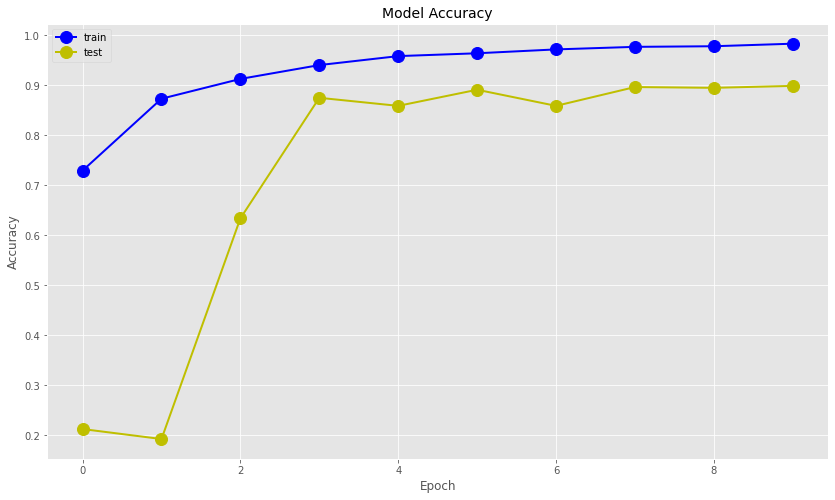

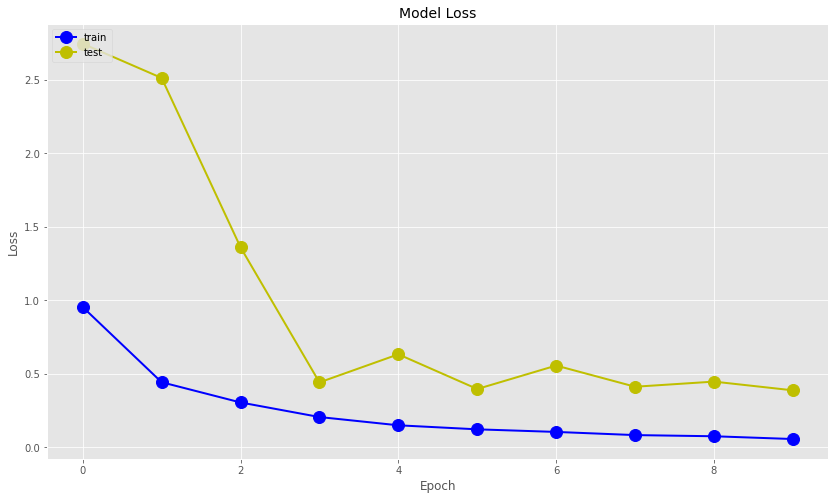

In [13]:
plt.figure(figsize=(14,8))
plt.plot(model_history.history['accuracy'], 'bo-', linewidth=2, markersize=12)
plt.plot(model_history.history['val_accuracy'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 # summarize history for loss
plt.figure(figsize=(14,8))
plt.plot(model_history.history['loss'], 'bo-', linewidth=2, markersize=12 )
plt.plot(model_history.history['val_loss'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
target_names = []
for key in training_set.class_indices:
  target_names.append(key)

print(target_names)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


# Confussion Matrix

41/41 [==============================] - 7s 158ms/step - loss: 0.3880 - accuracy: 0.8987
n Test_Accuracy:- 0.8986952900886536
confusion matrix
[[ 76   0   0   1   0   0   0   2   0   1   0   0   0]
 [  0  48   0   0   1   0   4   0   0   0   1   0   0]
 [  0   5 263   1   2   0   0   1   1   2   0   2   0]
 [  0   0   1 166   0   0   4   1   0   7   1   2   1]
 [  0   0   2   4 136   0   0   3   0   0   0   1   2]
 [  0   3   0   0   2  49   2   0   0   3   2   0   1]
 [  0   0   2   5   0   0  62   1   0   2   3   0   5]
 [  0   0   1   1   0   0   0  37   0   1   0   0   0]
 [  1   2   0   1   0   0   5   0  36   2   1   0   0]
 [  3   1   1   1   0   0   1   8   0  56   0   0   0]
 [  0   0   0   0   0   0   1   0   6   1  48   0   2]
 [  0   0   0   0   0   0   1   0   0   0   0 137   0]
 [  0   0   1   1   0   1   1   0   2   0   1   0  57]]


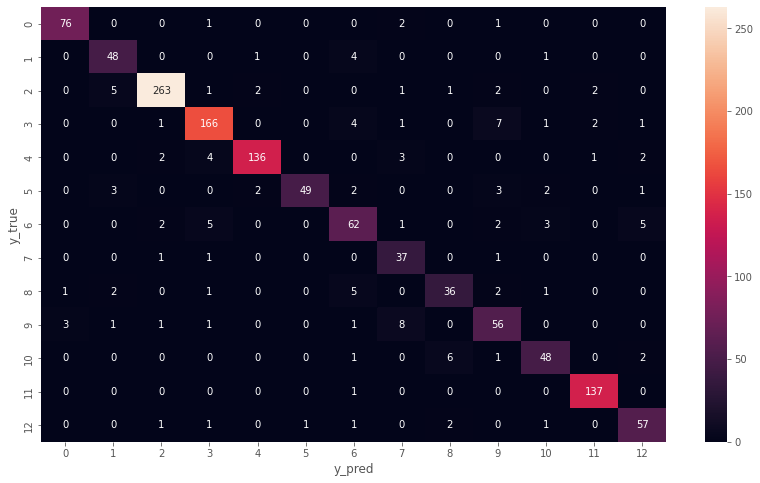

In [15]:
accuracy = model.evaluate(test_set)
print('n', 'Test_Accuracy:-', accuracy[1])
pred = model.predict(test_set)
y_pred = np.argmax(pred, axis=1)
#y_true = np.argmax(pred, axis=1)
print('confusion matrix')
print(confusion_matrix(test_set.classes, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(confusion_matrix(test_set.classes, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# Classification Report

In [25]:
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names ))

Classification Report
              precision    recall  f1-score   support

      0Capri       0.95      0.95      0.95        80
     10Pachy       0.81      0.89      0.85        54
     12Phyll       0.97      0.95      0.96       277
     14Macro       0.92      0.91      0.91       183
      1Pnoep       0.96      0.92      0.94       148
      2Malac       0.98      0.79      0.87        62
      3Malac       0.77      0.78      0.77        80
      4Anthi       0.70      0.93      0.80        40
      5Anthr       0.80      0.75      0.77        48
      6Corvu       0.75      0.79      0.77        71
      7Dryoc       0.84      0.83      0.83        58
      8Elanu       0.96      0.99      0.98       138
      9Ortho       0.84      0.89      0.86        64

    accuracy                           0.90      1303
   macro avg       0.87      0.87      0.87      1303
weighted avg       0.90      0.90      0.90      1303



In [26]:
target_names1 = []
for key in test_set.class_indices:
  target_names1.append(key)

print(target_names1)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


ROC AUC score: 0.9324919690843144


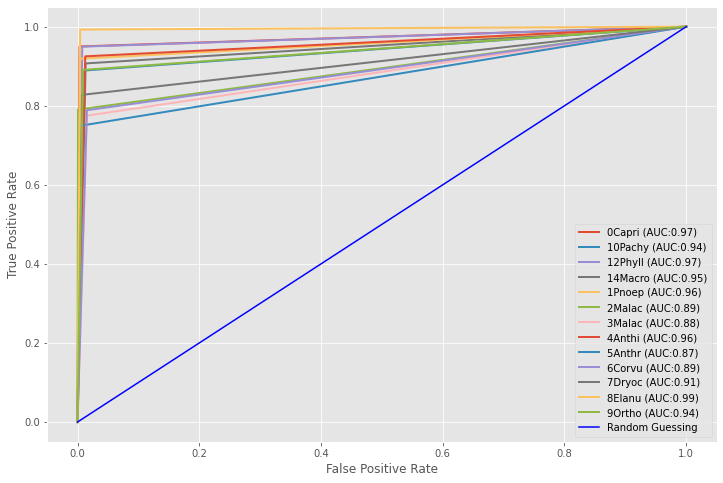

In [27]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_preds, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_preds = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names1):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_preds[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), linewidth=2)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_preds, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_set.classes, pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

# Top 1 and Top 5 Accuracy

In [19]:
top_k_accuracy_score(test_set.classes, pred, k=5)

0.9869531849577897

In [20]:
top_k_accuracy_score(test_set.classes, pred, k=5, normalize=False)

1286

In [21]:
top_k_accuracy_score(test_set.classes, pred, k=1)

0.898695318495779

In [22]:
top_k_accuracy_score(test_set.classes, pred, k=1, normalize=False)

1171

# Save Model weight

In [23]:
model.save('/content/drive/MyDrive/Birddata_split/M1_rmsprop_3.hdf5')

In [24]:
finalpreds = pd.DataFrame(y_pred)
finalpreds.to_csv('/content/drive/MyDrive/Birddata_split/M1_rmsprop_3.csv',index=False)